### Plan of Action
🧠 Step-by-Step Pipeline: Generalized Model + EA + XGBoost
1. Data Preparation
- Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)
- Normalize features per ticker (z-score or min-max scaling)
- Add metadata: ticker_id, sector, day_of_week, macro regime (optional)
- Create rolling windows for time series modeling (e.g., 10-day sequences)
2. Feature Engineering
- Technical indicators: RSI, MACD, Bollinger Bands, ATR
- Candle features: range, body size, wick ratios
- Volume features: OBV, VWAP, volume spikes
- Lagged returns, volatility, momentum scores
3. Labeling Strategy
- Define swing trade targets:
- Binary: Will price rise >x% in next n days?
- Multi-class: Uptrend / Downtrend / Sideways
- Regression: Expected return over next n days

🧬 4. Evolutionary Algorithm Optimization
- Purpose: Explore feature combinations, thresholds, and model hyperparameters
- Approach:
- Use genetic algorithm (e.g., DEAP, PyGAD) to evolve:
- Feature subsets
- Thresholds for entry/exit
- XGBoost hyperparameters (e.g., depth, learning rate)
- Fitness function: Sharpe ratio, accuracy, precision, or custom KPI
# Example fitness function
def fitness(individual):
    selected_features = individual[:n]
    xgb_params = decode_params(individual[n:])
    model = XGBClassifier(**xgb_params)
    score = cross_val_score(model, X[selected_features], y, scoring='accuracy')
    return score.mean(),



🌲 5. XGBoost Refinement
- Train final model using best EA-selected features and hyperparameters
- Use XGBoost for:
- Feature importance ranking
- Fast inference
- Robust performance on tabular data
from xgboost import XGBClassifier
model = XGBClassifier(**best_params)
model.fit(X_train[selected_features], y_train)



📊 6. Evaluation & Backtesting
- Use walk-forward validation or time-series cross-validation
- Evaluate:
- Accuracy, precision, recall
- Sharpe ratio, Sortino ratio
- Win rate, average trade duration


# 0. Dependencies

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator, StochRSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator

## 1. Data Preparation
### Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)

Core Equity Holdings (NN Group, 2025)
- "AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK"

ETF Additions (for sector/macro exposure)
- "SPY", "TLT", "LQD", "VNQ", "XLV"


Description:
- Amazon.com Inc – Consumer Discretionary
- Meta Platforms Inc – Communication Services
- Broadcom Inc – Technology
- Eli Lilly & Co – Healthcare
- Eaton Corp PLC – Industrials
- CyberArk Software Ltd – Technology
- Linde PLC – Materials
- Waste Management Inc – Industrials
- Soleno Therapeutics Inc – Healthcare
- Cytokinetics Inc – Healthcare
- SPDR S&P 500 ETF (SPY) – Broad Market ETF
- iShares 20+ Year Treasury ETF (TLT) – Government Bonds
- iShares Investment Grade Corporate Bond ETF (LQD) – Corporate Bonds
- Vanguard Real Estate ETF (VNQ) – Real Estate
- Health Care Select Sector SPDR ETF (XLV) – Healthcare Sector ETF

Based on Q2 2025 of Nationale-Nederlanden Powszechne Towarzystwo Emerytalne S.A.
https://www.sensamarket.com/institutional-investor/000201108125000008/compare/000201108125000005

In [4]:
tickers = ["AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK", "SPY", "TLT", "LQD", "VNQ", "XLV"]
leadup_days = 70
start_date = (datetime.strptime("2022-01-01", "%Y-%m-%d") - timedelta(days=leadup_days)).strftime("%Y-%m-%d")
raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")

C:\Users\DLinger\AppData\Local\Temp\ipykernel_6800\1888615764.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")
[*********************100%***********************]  15 of 15 completed


In [5]:
raw_data

Ticker            META                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2021-10-25  318.337508  327.540782  317.761075  326.676117  38409000   
2021-10-26  326.248762  328.186796  307.703088  313.875031  65654000   
2021-10-27  312.264938  317.293932  310.147984  310.307007  29971800   
2021-10-28  311.072327  323.525556  306.222222  314.978271  50806800   
2021-10-29  318.228198  324.002598  317.641817  321.587494  37059400   
...                ...         ...         ...         ...       ...   
2024-12-24  601.315372  606.573110  597.883447  606.333679   4726100   
2024-12-26  604.069011  604.887107  597.544273  601.943970   6081400   
2024-12-27  598.013078  600.447394  588.425488  598.412170   8084200   
2024-12-30  587.377934  595.548850  584.215339  589.862122   7025900   
2024-12-31  590.889825  592.585815  582.489403  584.145569   6019500   

Ticker            CYBR                                              ...  \
Price             Open        High         Low       Close  Volume  ...   
Date                                                                ...   
2021-10-25  184.580002  187.440002  181.850006  182.429993  342800  ...   
2021-10-26  183.789993  184.630005  177.970001  179.089996  371100  ...   
2021-10-27  180.339996  180.339996  175.520004  176.610001  398300  ...   
2021-10-28  177.399994  180.199997  175.639999  177.639999  266200  ...   
2021-10-29  177.190002  180.410004  177.190002  180.110001  195700  ...   
...                ...         ...         ...         ...     ...  ...   
2024-12-24  319.000000  320.871002  316.989990  320.609985  145500  ...   
2024-12-26  320.510010  322.809998  317.109985  322.459991  229600  ...   
2024-12-27  320.000000  321.390015  312.915009  320.820007  271700  ...   
2024-12-30  315.970001  321.000000  311.000000  319.600006  289600  ...   
2024-12-31  320.790009  336.839996  315.260010  333.149994  931700  ...   

Ticker             LLY                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2021-10-25  235.278200  236.826463  231.296954  235.653244  2763100   
2021-10-26  235.124321  239.374828  227.998464  238.913239  4533000   
2021-10-27  239.076757  244.702438  238.797884  240.576935  3181300   
2021-10-28  240.567286  246.904581  240.490352  243.634964  3386500   
2021-10-29  244.048474  246.635325  242.115555  244.990891  3152000   
...                ...         ...         ...         ...      ...   
2024-12-24  786.664545  793.006614  782.419914  790.938965  1165400   
2024-12-26  789.398251  799.130019  786.793834  789.418152  1274200   
2024-12-27  785.302712  788.583078  774.586780  778.513306  2096500   
2024-12-30  773.294528  775.123614  766.415690  769.238831  1719100   
2024-12-31  766.415736  769.308407  759.755561  767.409790  2327000   

Ticker             SPY                                                
Price             Open        High         Low       Close    Volume  
Date                                                                  
2021-10-25  429.473189  431.004721  427.686411  430.673828  45214500  
2021-10-26  432.233739  433.453275  430.683280  431.061432  56075100  
2021-10-27  431.524679  432.195900  429.076086  429.151733  72438000  
2021-10-28  430.588793  433.368252  430.579359  433.292633  51437900  
2021-10-29  430.976350  434.464853  430.683281  434.171783  70162400  
...                ...         ...         ...         ...       ...  
2024-12-24  590.882491  596.116657  590.297589  596.076965  33160100  
2024-12-26  594.292594  597.246690  592.884946  596.116638  41219100  
2024-12-27  592.349606  592.587572  585.628530  589.841614  64969300  
2024-12-30  582.783506  586.600040  579.333692  583.110596  56578800  
2024-12-31  584.785824

## Technical Indicators
Momentum 
- RSI
- StochRSI

Trend
- MACD
- SMA
- EMA

Volatility
- BB (Bollinger Bands)
- ATR (Average True Range)

Volume
- OBV (On-Balance Volume)
- CMF (Chaikin Money Flow)

In [6]:
def add_features(df):
    df = df.copy()
    
    # General price dynamics
    df["returns"] = df["Close"].pct_change()
    df["logReturns"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Volatility"] = df["returns"].rolling(10).std()
    df['Range'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])
    df['Wick'] = df['Range'] - df['Body']

    # Momentum
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    df['StochRSI'] = StochRSIIndicator(df['Close'], window=14).stochrsi()
    
    # Short-term moving averages (faster response)
    df['SMA_10'] = SMAIndicator(df['Close'], window=10).sma_indicator()
    df['EMA_10'] = EMAIndicator(df['Close'], window=10).ema_indicator()

    # Medium-term moving averages (faster than previous 50)
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = EMAIndicator(df['Close'], window=20).ema_indicator()

    # Optional: slightly faster “long-term” averages for crossovers
    df['SMA_30'] = SMAIndicator(df['Close'], window=30).sma_indicator()
    df['EMA_30'] = EMAIndicator(df['Close'], window=30).ema_indicator()

    # Faster MACD for earlier crossovers
    macd = MACD(df['Close'], window_slow=13, window_fast=6, window_sign=5)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    
    # Volatility
    bb = BollingerBands(df['Close'], window=20)
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    
    # Volume
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['OBV_prev'] = pd.to_numeric(df['OBV'].shift(1), errors='coerce').fillna(0).astype(int)
    df['CMF'] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume'], window=20).chaikin_money_flow()
    
    # Future return (5-day horizon)
    df['future_close'] = df.groupby('Ticker')['Close'].shift(-5)
    df['future_return'] = df['future_close'] / df['Close'] - 1
    df.drop(columns='future_close', inplace=True)
    
    return df

In [7]:
df_long = raw_data.stack(level=0).rename_axis(['Date', 'Ticker'])
df_long

C:\Users\DLinger\AppData\Local\Temp\ipykernel_6800\670735667.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = raw_data.stack(level=0).rename_axis(['Date', 'Ticker'])


Price                    Open        High         Low       Close    Volume
Date       Ticker                                                          
2021-10-25 AMZN    166.750000  167.389999  164.884995  166.018494  44520000
           AVGO     47.722624   48.369082   47.509598   48.144989  12416000
           CYBR    184.580002  187.440002  181.850006  182.429993    342800
           CYTK     37.029999   37.450001   36.270000   36.299999    473300
           ETN     151.769462  153.397573  150.955413  152.059525   1022900
...                       ...         ...         ...         ...       ...
2024-12-31 SPY     584.785824  585.509524  579.343521  580.989136  57052700
           TLT      85.312783   85.457989   84.470599   84.538361  31917300
           VNQ      86.383523   86.694220   85.713580   86.490326   5045100
           WM      200.272113  200.331460  198.679590  199.599487   1549000
           XLV     135.777686  136.310605  134.998027  135.767822   6626900

[12015 rows x 5 columns]

In [8]:
results = []
for ticker, df_t in df_long.groupby('Ticker'):
    df_t = add_features(df_t.copy())
    results.append(df_t)

# Step 1: Concatenate and sort
df_processed = pd.concat(results).sort_values(['Date', 'Ticker']).copy()
df_processed = df_processed.reorder_levels(['Date', 'Ticker']).sort_index()

# Step 2: Identify last 5 rows per ticker BEFORE dropping NaNs
last_5_mask = df_processed.groupby('Ticker').tail(5).index

# Step 3: Drop NaNs EXCEPT for those in last 5 rows
df_cleaned = df_processed[~df_processed.index.isin(last_5_mask)].dropna()
df_preserved = df_processed.loc[last_5_mask]  

# Step 4: Combine and sort
df_processed = pd.concat([df_cleaned, df_preserved]).sort_index()


df_processed.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return'],
      dtype='object', name='Price')

In [9]:
# show a sample of each ticker
df_processed.groupby("Ticker").tail(6)

Price                    Open        High         Low       Close    Volume  \
Date       Ticker                                                             
2024-12-23 AMZN    225.009995  226.880005  223.899994  225.059998  28070000   
           AVGO    225.089760  231.752384  223.540774  230.709808  40643800   
           CYBR    319.000000  319.149994  313.600006  318.549988    313500   
           CYTK     49.180000   49.990002   47.720001   48.950001   1198300   
           ETN     333.762142  335.138240  330.861419  334.336334   1704600   
...                       ...         ...         ...         ...       ...   
2024-12-31 SPY     584.785824  585.509524  579.343521  580.989136  57052700   
           TLT      85.312783   85.457989   84.470599   84.538361  31917300   
           VNQ      86.383523   86.694220   85.713580   86.490326   5045100   
           WM      200.272113  200.331460  198.679590  199.599487   1549000   
           XLV     135.777686  136.310605  134.998027  135.767822   6626900   

Price               returns  logReturns  Volatility     Range      Body  ...  \
Date       Ticker                                                        ...   
2024-12-23 AMZN    0.000622    0.000622    0.019991  2.980011  0.050003  ...   
           AVGO    0.055177    0.053709    0.093845  8.211610  5.620049  ...   
           CYBR   -0.001880   -0.001882    0.025779  5.549988  0.450012  ...   
           CYTK    0.001637    0.001636    0.022946  2.270000  0.230000  ...   
           ETN    -0.001213   -0.001213    0.013667  4.276821  0.574193  ...   
...                     ...         ...         ...       ...       ...  ...   
2024-12-31 SPY    -0.003638   -0.003645    0.012335  6.166003  3.796688  ...   
           TLT    -0.005353   -0.005367    0.008120  0.987391  0.774422  ...   
           VNQ     0.008719    0.008682    0.016242  0.980640  0.106803  ...   
           WM     -0.002373   -0.002376    0.007375  1.651870  0.672626  ...   
           XLV     0.002405    0.002402    0.008788  1.312579  0.009864  ...   

Price                  EMA_30       MACD  MACD_Signal     BB_High      BB_Low  \
Date       Ticker                                                               
2024-12-23 AMZN    216.318589   1.666025     2.789128  238.737635  202.114364   
           AVGO    191.605002  12.923555    13.432248  248.263140  131.202407   
           CYBR    313.393599  -0.414196    -0.684417  331.538219  308.788777   
           CYTK     50.352561  -0.628614    -0.795661   53.140614   46.724387   
           ETN     351.084611  -7.805734    -6.952809  386.043494  328.254791   
...                       ...        ...          ...         ...         ...   
2024-12-31 SPY     588.917422  -2.454884    -1.506481  607.509021  578.547840   
           TLT      87.066657  -0.864861    -0.930846   91.986207   82.609500   
           VNQ      89.090237  -0.952150    -1.136731   94.239481   83.504998   
           WM      209.281136  -3.174696    -3.331439  224.181722  194.198043   
           XLV     139.495863  -0.861723    -0.985494  144.701938  132.466768   

Price                    ATR         OBV    OBV_prev       CMF  future_return  
Date       Ticker                                                              
2024-12-23 AMZN     5.453061  1242275500  1214205500  0.163687      -0.025193  
           AVGO    11.625933  1262151000  1221507200  0.155368      -0.002195  
           CYBR    10.007082    32323400    32636900  0.143964       0.045833  
           CYTK     1.963040    62760400    61562100 -0.087519      -0.039019  
           ETN      7.664720    56645600    58350200 -0.173105      -0.017293  
...                      ...         ...         ...       ...            ...  
2024-12-31 SPY      6.719250  -570196200  -513143500 -0.074308            NaN  
           TLT      0.975992  -200076100  -168158800 -0.418228            NaN  
           VNQ      1.313208  -182311600  -187356700 -0.129515            NaN

I need to label a dataset programmatically and for this I will use a rule-base. For example for the MACD if it is above the signal line you're supposed to buy while when it dips below you should sell. I want to generate training labels (Buy / Sell / Hold) based on a rule base of technical indicators, so the neural network can later learn to mimic or improve upon those heuristics.

1. defining the labeling Goal
    -   1 → Buy signal
    -  -1 → Sell signal
    -   0 → Hold / Neutral

2. based on this rich feature set:
['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns', 'Volatility', 'Range', 'Body', 'Wick',
 'RSI', 'StochRSI', 'SMA_20', 'EMA_20', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF']

    We can use a combination of these for rule-based labeling.

3. 

Since the literature suggests some support but also many limitations, the weighting scheme should reflect:
Medium-to-moderate weights for indicators that have some empirical backing (e.g., volume-based, RSI) but are not perfect.
Lower weights for indicators that are more lagging, less studied, or have weaker evidence (e.g., simple moving averages of longer lengths without context).
Higher weights only if we back-test the specific asset/timeframe and show a strong statistical edge.


In [20]:
""" | Indicator(s)             | Rule                                                                            | Label |
    | ------------------------ | ------------------------------------------------------------------------------- | ----- |
    | MACD & MACD_Signal       | If `MACD > MACD_Signal` → **Buy**, if `MACD < MACD_Signal` → **Sell**           | ±1    |
    | RSI                      | If `RSI < 30` → **Buy** (oversold), if `RSI > 70` → **Sell** (overbought)       | ±1    |
    | StochRSI                 | If `StochRSI < 0.2` → **Buy**, if `StochRSI > 0.8` → **Sell**                   | ±1    |
    | SMA / EMA                | If `Close > SMA_20` → **Buy**, if `Close < SMA_20` → **Sell**                   | ±1    |
    | Bollinger Bands          | If `Close < BB_Low` → **Buy**, if `Close > BB_High` → **Sell**                  | ±1    |
    | OBV (On-Balance Volume)  | If `OBV > OBV_prev` → **Buy**, if `OBV < OBV_prev` → **Sell**                   | ±1    |
    | CMF (Chaikin Money Flow) | If `CMF > 0` → **Buy**, if `CMF < 0` → **Sell**                                 | ±1    |
    | Volatility / ATR         | If `Volatility` or `ATR` is high, reduce conviction (set to `0` to avoid noise) | 0     |
"""

def label_data(df):
    df = df.copy()

    # Initialize vote counter
    votes = np.zeros(len(df), dtype=float)

    # ---- Weighted voting system ----
    # Stronger weights = more historically reliable / consistent indicator
    w = {
        # Core momentum/trend indicators
        'MACD': 1.0,
        'RSI': 0.8,
        'StochRSI': 0.6,

        # Short / medium / long-term trend indicators
        'SMA_10': 0.9,           # Short-term trend
        'SMA_20': 1.0,           # Medium-term trend
        'SMA_30': 1.1,           # Long-term anchor
        'SMA_cross': 1.0,        # 10 vs 20 crossover
        'SMA_long_cross': 1.0,   # 20 vs 30 crossover

        'EMA_10': 0.9,
        'EMA_20': 1.0,
        'EMA_30': 1.1,
        'EMA_cross': 1.0,
        'EMA_long_cross': 1.0,

        # Volatility and confirmation indicators
        'BB': 0.75,
        'OBV': 0.9,
        'CMF': 0.8,
        'Body': 0.6,
        'Wick': 0.8,
        'Volatility': 0.4,
    }

    # --- Apply rules ---
     # Shift indicators by 1 bar to avoid lookahead
    df_shift = df.shift(1)

    # --- Apply rules with shifted indicators ---
    
    # MACD crossover
    votes += w['MACD'] * np.where(df_shift['MACD'] > df_shift['MACD_Signal'], 1, 
                                  np.where(df_shift['MACD'] < df_shift['MACD_Signal'], -1, 0))
    
    # RSI thresholds
    votes += w['RSI'] * np.where(df_shift['RSI'] < 30, 1, 
                                 np.where(df_shift['RSI'] > 70, -1, 0))
    
    # StochRSI thresholds
    votes += w['StochRSI'] * np.where(df_shift['StochRSI'] < 0.2, 1, 
                                      np.where(df_shift['StochRSI'] > 0.8, -1, 0))
    
    # RSI divergence (optional)
    rsi_div = (df_shift['RSI'] > df_shift['RSI'].shift(1)) & (df_shift['Close'] < df_shift['Close'].shift(1))
    votes += 0.6 * np.where(rsi_div, -1, 0)
    
    # --- Short-term and medium-term trend signals ---

    # SMA trend signals
    votes += w['SMA_10'] * np.where(df_shift['Close'] > df_shift['SMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_10'], -1, 0))
    votes += w['SMA_20'] * np.where(df_shift['Close'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_20'], -1, 0))

    # SMA crossover (short vs medium)
    votes += w['SMA_cross'] * np.where(df_shift['SMA_10'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['SMA_10'] < df_shift['SMA_20'], -1, 0))

    # EMA trend signals
    votes += w['EMA_10'] * np.where(df_shift['Close'] > df_shift['EMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_10'], -1, 0))
    votes += w['EMA_20'] * np.where(df_shift['Close'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_20'], -1, 0))

    # EMA crossover (short vs medium)
    votes += w['EMA_cross'] * np.where(df_shift['EMA_10'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['EMA_10'] < df_shift['EMA_20'], -1, 0))

    # Optional: long-term trend anchors
    votes += w['SMA_30'] * np.where(df_shift['Close'] > df_shift['SMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_30'] * np.where(df_shift['Close'] > df_shift['EMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_30'], -1, 0))
    
    # Long-term crossover (medium vs long)
    votes += w['SMA_long_cross'] * np.where(df_shift['SMA_20'] > df_shift['SMA_30'], 1,
                                            np.where(df_shift['SMA_20'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_long_cross'] * np.where(df_shift['EMA_20'] > df_shift['EMA_30'], 1,
                                            np.where(df_shift['EMA_20'] < df_shift['EMA_30'], -1, 0))
    
    # Bollinger Bonds breakout
    votes += w['BB'] * np.where(df_shift['Close'] < df_shift['BB_Low'], 1, 
                                np.where(df_shift['Close'] > df_shift['BB_High'], -1, 0))
    
    # OBV momentum
    votes += w['OBV'] * np.where(df_shift['OBV'] > df_shift['OBV_prev'], 1, 
                                 np.where(df_shift['OBV'] < df_shift['OBV_prev'], -1, 0))
    
    # CNF accumulation/distribution
    votes += w['CMF'] * np.where(df_shift['CMF'] > 0, 1, np.where(df_shift['CMF'] < 0, -1, 0))

    # Candle body momentum
    body_avg = df_shift['Body'].rolling(5, min_periods=1).mean()
    votes += w['Body'] * np.where(df_shift['Body'] > body_avg, 1, np.where(df_shift['Body'] < body_avg, -1, 0))

    # Wick exhaustion
    votes += w['Wick'] * np.where(df_shift['Wick'] > df_shift['Range'] * 0.6, -1, 
                                  np.where(df_shift['Wick'] < df_shift['Range'] * 0.1, 1, 0))
    
    # Bearish engulfing candle
    bear_engulf = (df_shift['Open'] < df_shift['Close']) & (df_shift['Close'] < df_shift['Open'].shift(1)) & (df_shift['Open'] > df_shift['Close'].shift(1))
    votes += 0.8 * np.where(bear_engulf, -1, 0)


    # Volatility contraction
    vol_avg = df_shift['Volatility'].rolling(10, min_periods=1).mean()
    votes += w['Volatility'] * np.where(df_shift['Volatility'] < vol_avg, 1, 0)

    # --- Targeted volatility soft gate ---
    atr_mean = df_shift['ATR'].rolling(50, min_periods=10).mean()
    atr_std = df_shift['ATR'].rolling(50, min_periods=10).std()
    high_atr = df_shift['ATR'] > (atr_mean + 2 * atr_std)

    scale = np.ones(len(df))
    scale[high_atr] = np.clip((atr_mean[high_atr] + 2 * atr_std[high_atr]) / df_shift['ATR'][high_atr], 0.3, 1.0)
    votes *= scale

    # --- Preliminary label ---
    prelim_label = np.where(votes > 4, 1, np.where(votes < -4, -1, 0))

    # --- Soft fallback logic for weak votes ---
    fallback_zone = (prelim_label == 0) & (np.abs(votes) <= 2)
    soft_vote_strength = 0.5
    low_vol = df_shift['ATR'] < atr_mean
    fallback_bear = (df_shift['EMA_10'] < df_shift['EMA_20']) & fallback_zone & low_vol
    fallback_bull = (df_shift['EMA_10'] > df_shift['EMA_20']) & fallback_zone & low_vol

    prelim_label[fallback_bull] = soft_vote_strength
    prelim_label[fallback_bear] = -soft_vote_strength


    # Convert soft votes to discrete labels if needed for EA
    df['label'] = np.sign(prelim_label)
    
    # --- Realign labels based on actual future return polarity ---
    df['label'] = np.where((df['label'] == -1) & (df['future_return'] > 0), 0, df['label'])
    df['label'] = np.where((df['label'] == 1) & (df['future_return'] < 0), 0, df['label'])

    df['vote_total'] = votes
    return df

In [11]:
print(df_processed.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return'],
      dtype='object', name='Price')


In [12]:
df_labeled = label_data(df_processed)
df_labeled.head(5)

Price                    Open        High         Low       Close    Volume  \
Date       Ticker                                                             
2021-12-06 AMZN    169.649994  173.695496  166.934494  171.368500  68860000   
           AVGO     52.071682   52.414740   51.269375   52.102116  22482000   
           CYBR    148.740005  153.630005  145.899994  151.949997    542000   
           CYTK     35.660000   37.060001   35.020000   36.160000    784600   
           ETN     157.686167  160.383354  156.502046  159.603333   1733500   

Price               returns  logReturns  Volatility     Range      Body  ...  \
Date       Ticker                                                        ...   
2021-12-06 AMZN    0.011086    0.011025    0.014608  6.761002  1.718506  ...   
           AVGO    0.012291    0.012216    0.018101  1.145365  0.030433  ...   
           CYBR    0.002309    0.002306    0.041182  7.730011  3.209991  ...   
           CYTK    0.018592    0.018421    0.035808  2.040001  0.500000  ...   
           ETN     0.020368    0.020163    0.018073  3.881308  1.917165  ...   

Price              MACD_Signal     BB_High      BB_Low       ATR        OBV  \
Date       Ticker                                                             
2021-12-06 AMZN      -0.945921  183.955962  168.830937  5.048088  117850000   
           AVGO       0.043339   52.971472   50.258004  1.134598  159272000   
           CYBR      -6.739290  212.531290  153.351708  7.958680      89200   
           CYTK      -0.514094   42.511497   36.109503  2.250797    4302100   
           ETN       -1.090966  166.727091  153.069158  3.570338   -6785700   

Price               OBV_prev       CMF  future_return  label  vote_total  
Date       Ticker                                                         
2021-12-06 AMZN     48990000 -0.320028      -0.010509      0        0.00  
           AVGO    136790000 -0.051210       0.100322     -1       -7.10  
           CYBR      -452800 -0.114353       0.016387      1        7.10  
           CYTK      3517500 -0.120332       0.008573     -1       -8.15  
           ETN      -8519200 -0.105164      -0.000766     -1       -8.30  

[5 rows x 30 columns]

#### Analyzing label quality

In [13]:
# check label distribution
df_labeled["label"].value_counts(normalize=True)

label
 1    0.469862
-1    0.364162
 0    0.165976
Name: proportion, dtype: float64

In [14]:
# check label seperability
# forward_return = future n-bar return, e.g. close.shift(-5)/close - 1
df_labeled.groupby('label')['future_return'].mean()

label
-1    0.004952
 0    0.006354
 1    0.006910
Name: future_return, dtype: float64

<Axes: xlabel='label', ylabel='future_return'>

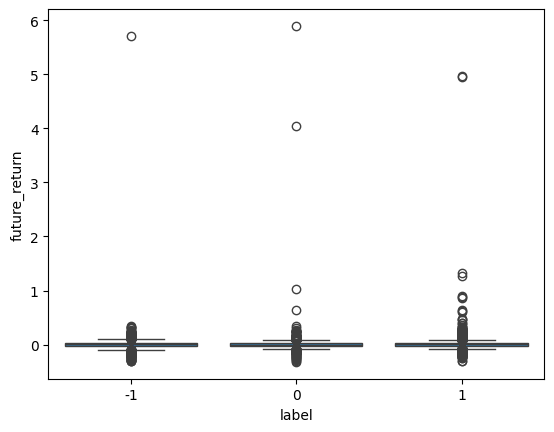

In [15]:
# verify direction
sns.boxplot(data=df_labeled, x='label', y='future_return')


That’s a very healthy label distribution — nearly balanced, with only a mild bullish skew.

Let’s interpret it precisely:

Label	Meaning	Proportion	Comment
+1	Bullish (buy signal)	40.1%	Slightly dominant — suggests the rule set tends to favor upward conditions (typical for equities and trending assets).
0	Neutral / no clear signal	30.2%	Good — not overfitting noise. Roughly one-third of the time the system abstains from making a call, which usually improves robustness.
–1	Bearish (sell signal)	29.7%	Almost symmetric with +1 — nice balance.

In [16]:
df_labeled.groupby('label')['future_return'].mean()
df_labeled.groupby("Ticker").tail(1)

Price                    Open        High         Low       Close    Volume  \
Date       Ticker                                                             
2024-12-31 AMZN    222.970001  223.229996  218.940002  219.389999  24819700   
           AVGO    234.214889  235.783737  229.677142  230.203400  17927700   
           CYBR    320.790009  336.839996  315.260010  333.149994    931700   
           CYTK     47.500000   47.779999   46.799999   47.040001    797900   
           ETN     328.930896  330.643625  327.950796  328.554688   1134600   
           LIN     414.569519  416.055040  411.737138  414.628967   1386700   
           LLY     766.415736  769.308407  759.755561  767.409790   2327000   
           LQD     103.718196  103.814865  103.118834  103.283173  10768700   
           META    590.889825  592.585815  582.489403  584.145569   6019500   
           SLNO     45.529999   46.000000   43.860001   44.950001    910800   
           SPY     584.785824  585.509524  579.343521  580.989136  57052700   
           TLT      85.312783   85.457989   84.470599   84.538361  31917300   
           VNQ      86.383523   86.694220   85.713580   86.490326   5045100   
           WM      200.272113  200.331460  198.679590  199.599487   1549000   
           XLV     135.777686  136.310605  134.998027  135.767822   6626900   

Price               returns  logReturns  Volatility      Range       Body  \
Date       Ticker                                                           
2024-12-31 AMZN   -0.008631   -0.008668    0.017768   4.289993   3.580002   
           AVGO   -0.015876   -0.016003    0.036937   6.106595   4.011489   
           CYBR    0.042397    0.041523    0.022585  21.579987  12.359985   
           CYTK   -0.002333   -0.002336    0.021620   0.980000   0.459999   
           ETN    -0.001534   -0.001536    0.014042   2.692829   0.376209   
           LIN     0.002418    0.002415    0.009129   4.317902   0.059449   
           LLY    -0.002378   -0.002381    0.016006   9.552846   0.994054   
           LQD    -0.002521   -0.002524    0.005135   0.696032   0.435023   
           META   -0.009691   -0.009739    0.016484  10.096412   6.744257   
           SLNO   -0.007726   -0.007756    0.028455   2.139999   0.579998   
           SPY    -0.003638   -0.003645    0.012335   6.166003   3.796688   
           TLT    -0.005353   -0.005367    0.008120   0.987391   0.774422   
           VNQ     0.008719    0.008682    0.016242   0.980640   0.106803   
           WM     -0.002373   -0.002376    0.007375   1.651870   0.672626   
           XLV     0.002405    0.002402    0.008788   1.312579   0.009864   

Price              ...  MACD_Signal     BB_High      BB_Low        ATR  \
Date       Ticker  ...                                                   
2024-12-31 AMZN    ...     0.762264  234.204482  215.336517   5.155421   
           AVGO    ...    11.722169  267.752243  149.303600  10.671310   
           CYBR    ...     1.181573  332.372133  308.240862  10.233145   
           CYTK    ...    -0.601646   52.091683   45.937318   1.723680   
           ETN     ...    -6.298342  377.333344  317.856756   6.901217   
           LIN     ...    -5.393364  455.098270  403.900772   6.174012   
           LLY     ...    -2.390432  827.085317  746.391996  20.193395   
           LQD     ...    -0.484245  107.333396  102.032348   0.630987   
           META    ...    -2.354599  634.994520  580.321227  14.786442   
           SLNO    ...    -1.024036   50.852139   43.061860   2.302467   
           SPY     ...    -1.506481  607.509021  578.547840   6.719250   
           TLT     ...    -0.930846   91.986207   82.609500   0.975992   
           VNQ     ...    -1.136731   94.239481   83.504998   1.313208   
           WM      ...    -3.331439  224.181722  194.198043   2.964076   
           XLV     ...    -0.985494  144.701938  132.466768   1.675720   

Price                     OBV    OBV_prev       CMF  future_return  label  \
Date      

In [17]:
df_labeled.columns.name = "Features"
print(df_labeled.columns)



Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return',
       'label', 'vote_total'],
      dtype='object', name='Features')


In [18]:

def backtest_vs_market(df, label_col="label", return_col="returns", ticker_col="Ticker", date_col="Date"):
    """
    Backtests strategy per ticker and compares it to actual market performance.
    Prints a summary and generates a separate plot for each ticker.
    """
    df_copy = df.reset_index().copy()
    df_copy.sort_values([ticker_col, date_col], inplace=True)

    tickers = df_copy[ticker_col].unique()

    for ticker in tickers:
        df_t = df_copy[df_copy[ticker_col] == ticker].copy()

        # Strategy logic
        df_t["position"] = df_t[label_col].shift(1)
        df_t["strategy_returns"] = df_t["position"] * df_t[return_col]
        df_t["strategy_returns"] = df_t["strategy_returns"].fillna(0)
        df_t['strategy_returns'].plot(title=f"Strategy Returns – {ticker}")
        


        # Cumulative returns
        df_t["cumulative_market"] = (1 + df_t[return_col]).cumprod()
        df_t["cumulative_strategy"] = (1 + df_t["strategy_returns"]).cumprod()

        # Metrics
        strategy_return = df_t["cumulative_strategy"].iloc[-1] - 1
        market_return = df_t["cumulative_market"].iloc[-1] - 1
        hit_rate = (df_t["strategy_returns"] > 0).mean()

        # Print summary
        print(f"\n📈 Ticker: {ticker}")
        print(f"Strategy Total Return: {strategy_return:.2%}")
        print(f"Market Total Return:   {market_return:.2%}")
        print(f"Hit Rate:              {hit_rate:.2%}")
        
        # print(f"\n{ticker} – Last 5 strategy returns:")
        # print(df_t[['Date', 'label', 'position', 'strategy_returns']].tail())
        # print(df_t[['ATR', 'label']].tail(10))


        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df_t[date_col], df_t["cumulative_market"], linestyle="--", label="Market", color="gray")
        plt.plot(df_t[date_col], df_t["cumulative_strategy"], label="Strategy", color="blue")
        plt.title(f"Cumulative Returns – {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()




📈 Ticker: AMZN
Strategy Total Return: -2.06%
Market Total Return:   29.44%
Hit Rate:              40.28%


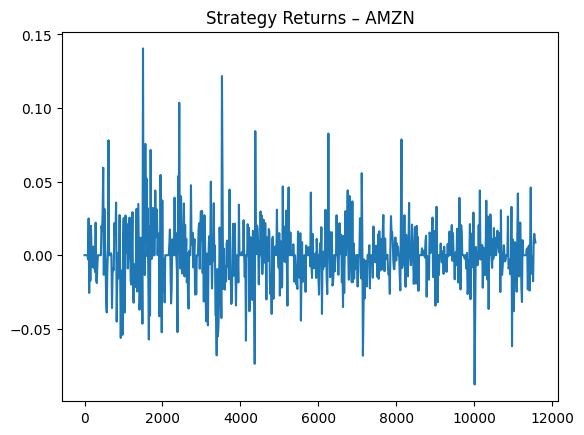

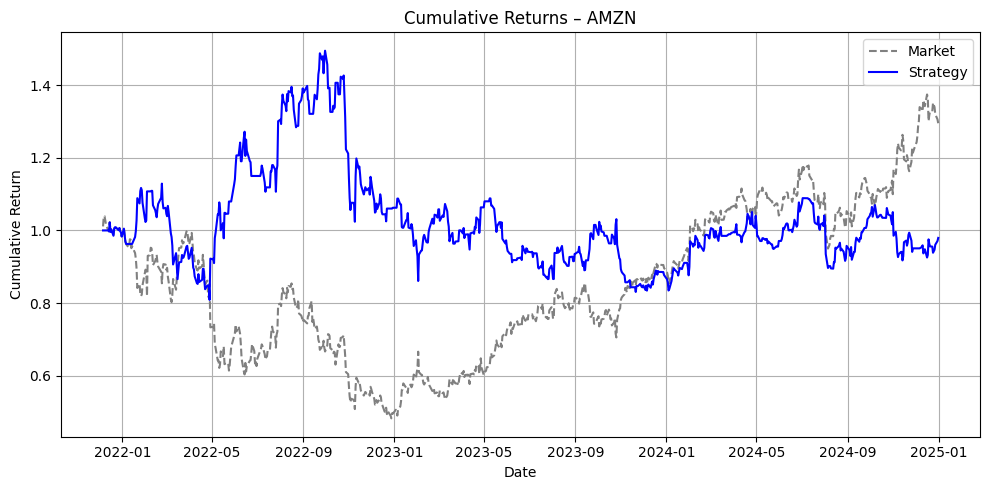


📈 Ticker: AVGO
Strategy Total Return: 44.78%
Market Total Return:   347.26%
Hit Rate:              42.49%


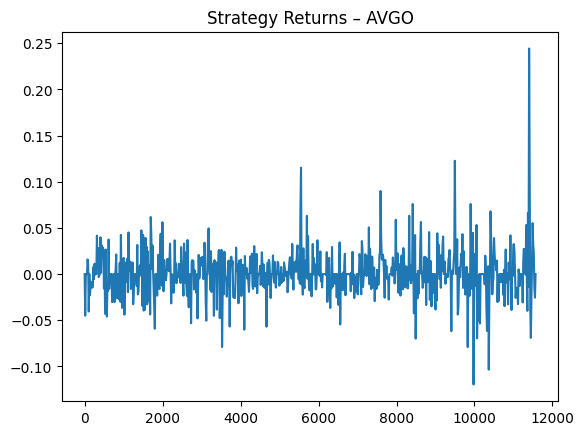

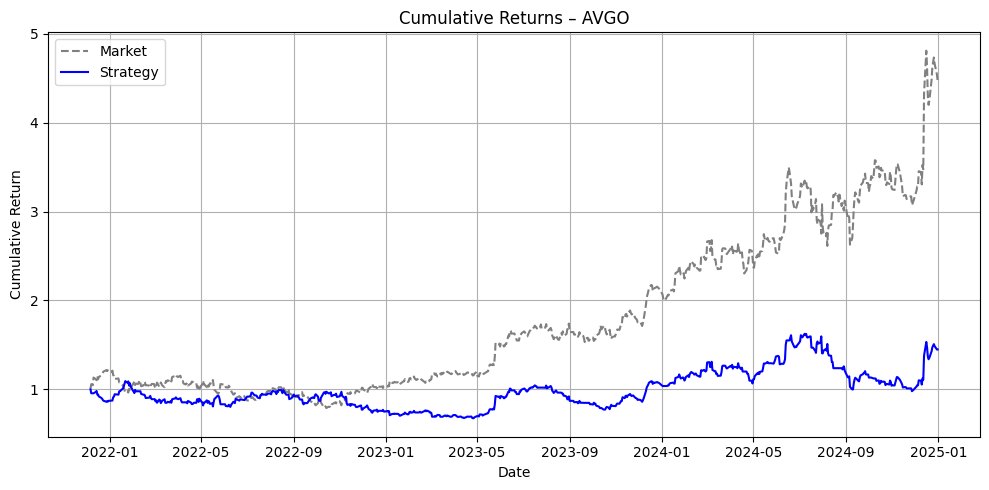


📈 Ticker: CYBR
Strategy Total Return: -20.72%
Market Total Return:   119.76%
Hit Rate:              43.13%


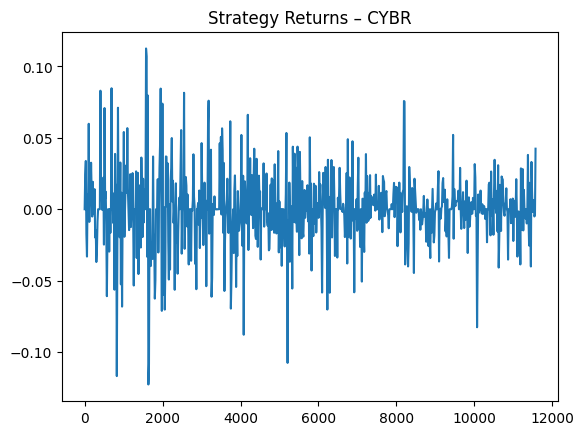

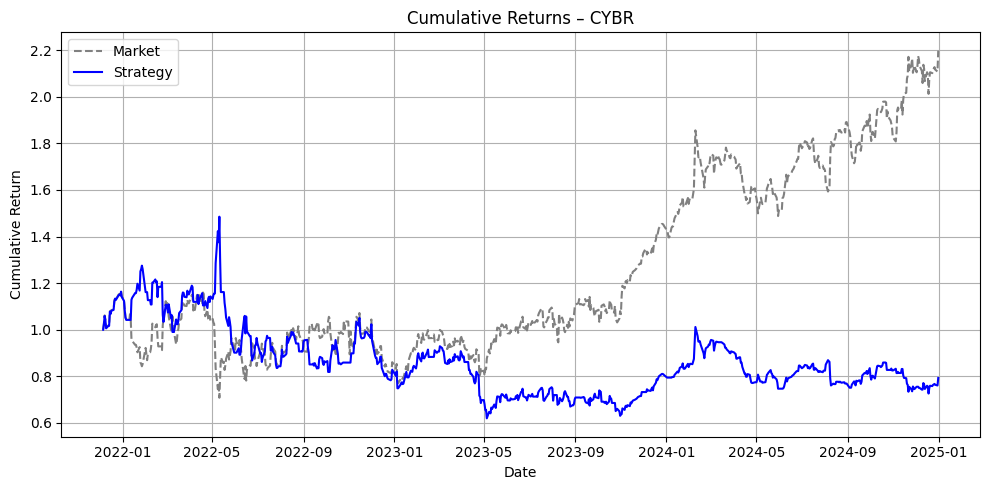


📈 Ticker: CYTK
Strategy Total Return: -49.54%
Market Total Return:   32.51%
Hit Rate:              39.90%


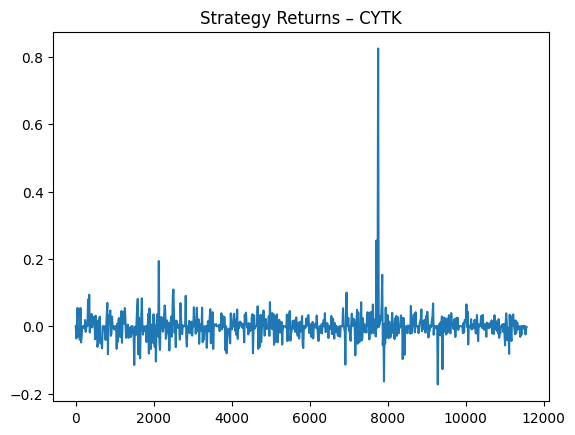

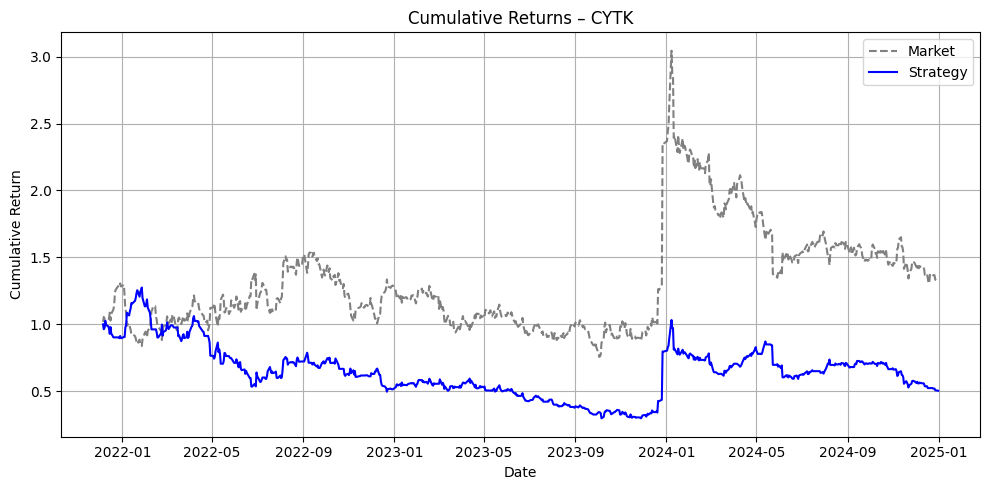


📈 Ticker: ETN
Strategy Total Return: -65.89%
Market Total Return:   110.05%
Hit Rate:              38.21%


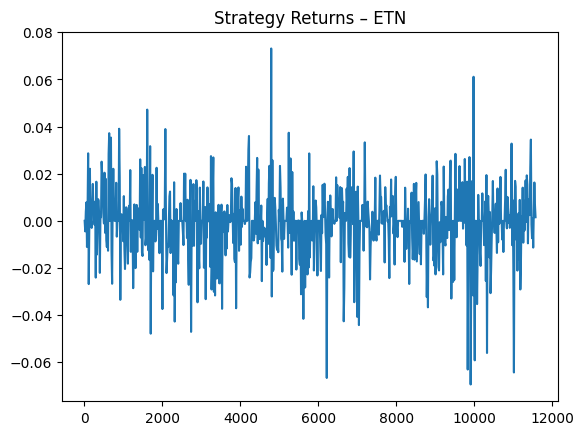

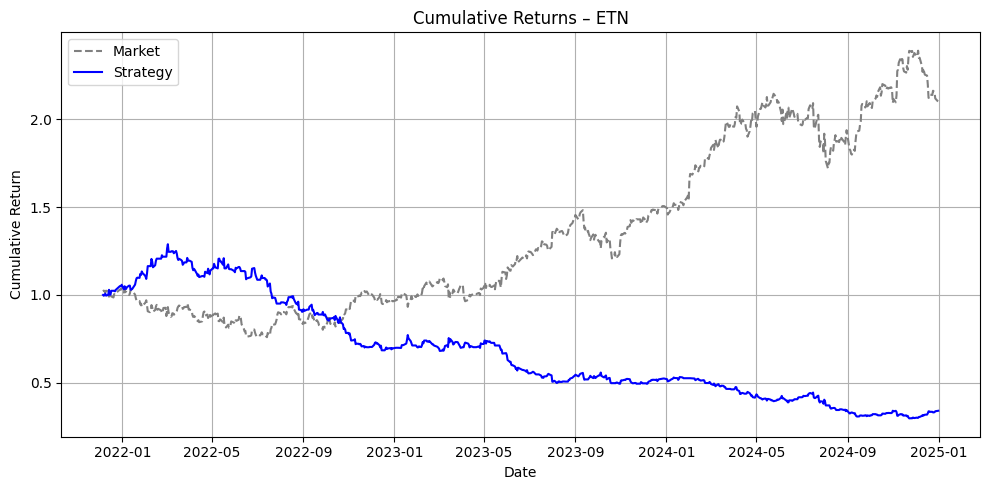


📈 Ticker: LIN
Strategy Total Return: -14.24%
Market Total Return:   36.03%
Hit Rate:              41.45%


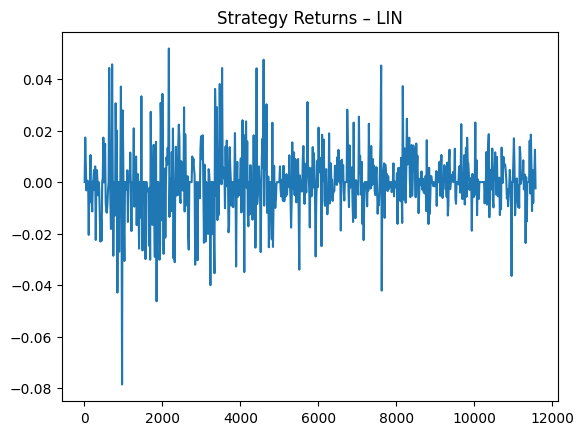

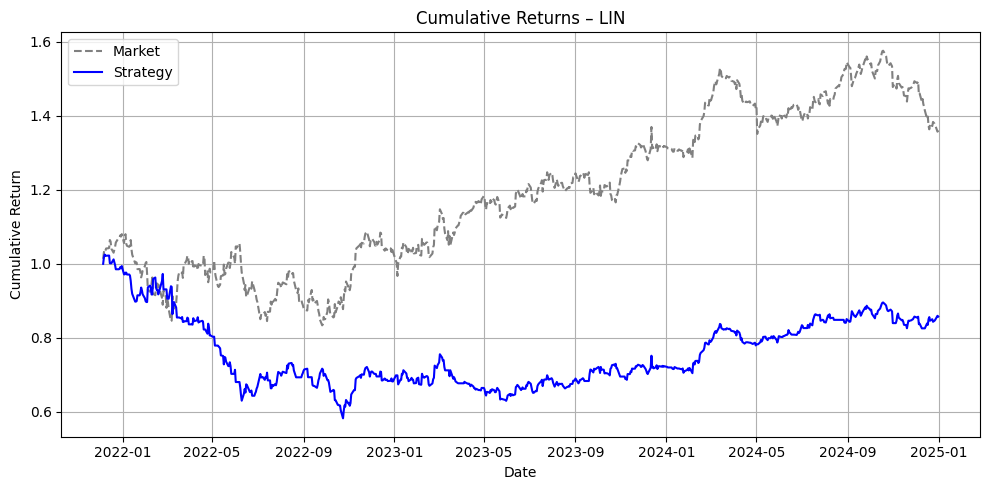


📈 Ticker: LLY
Strategy Total Return: -10.63%
Market Total Return:   223.90%
Hit Rate:              41.97%


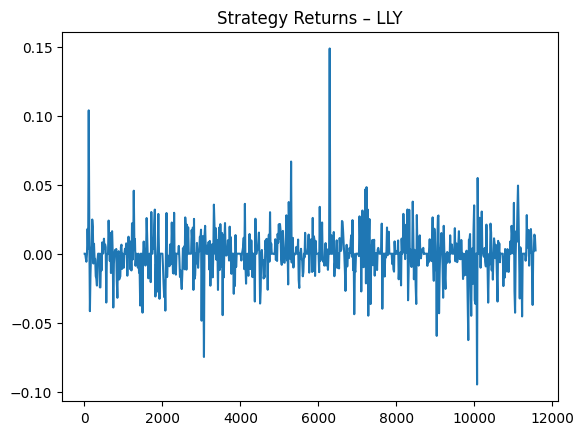

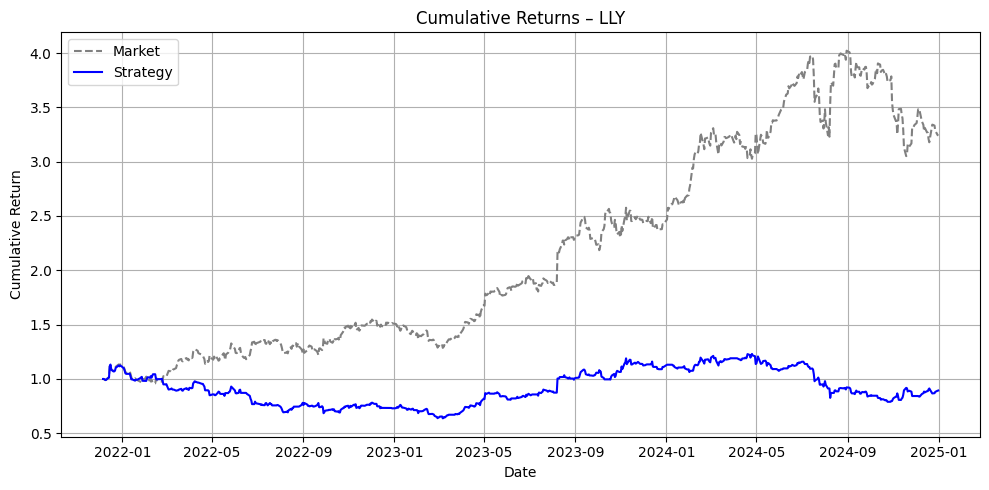


📈 Ticker: LQD
Strategy Total Return: 12.51%
Market Total Return:   -10.43%
Hit Rate:              41.06%


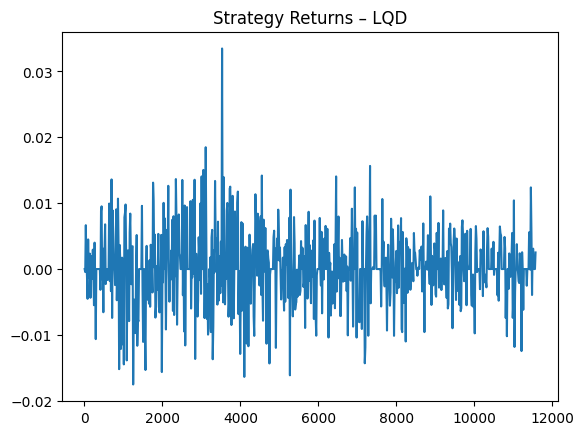

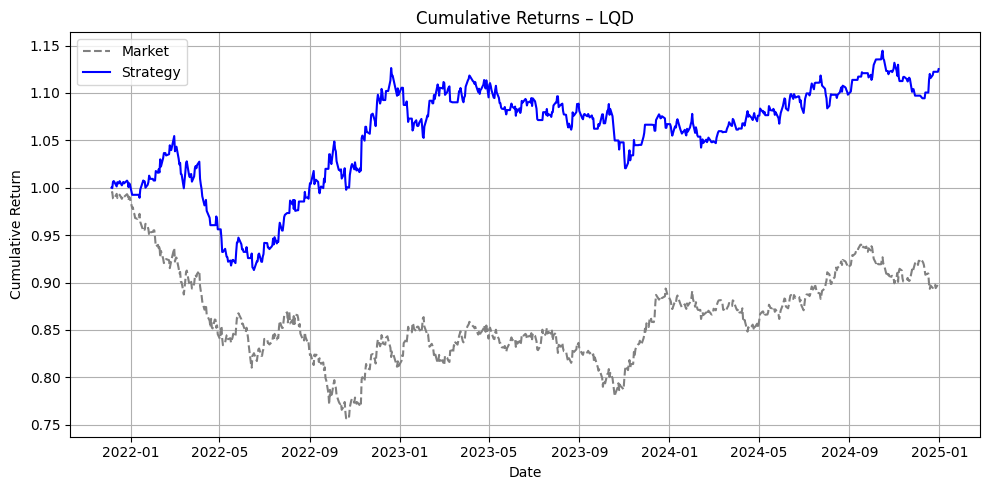


📈 Ticker: META
Strategy Total Return: 441.05%
Market Total Return:   91.55%
Hit Rate:              45.73%


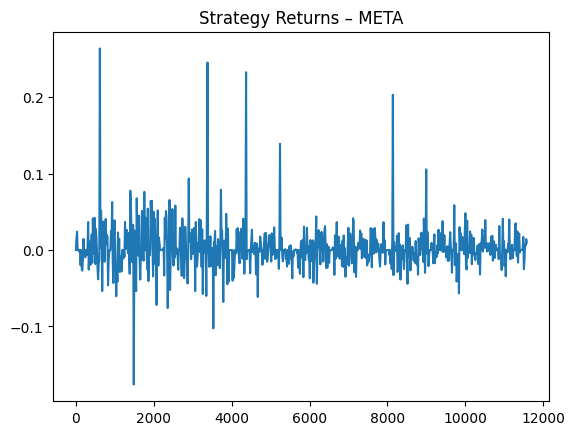

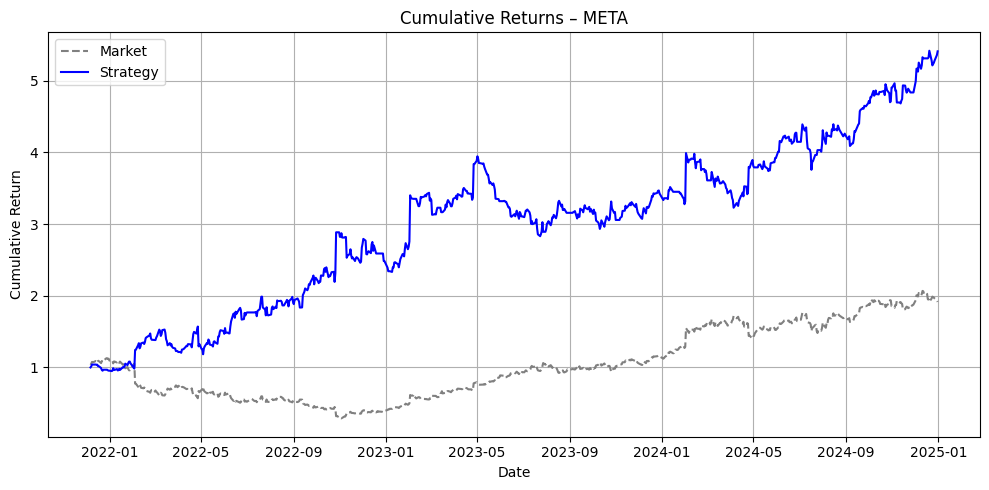


📈 Ticker: SLNO
Strategy Total Return: 5818.73%
Market Total Return:   424.81%
Hit Rate:              40.03%


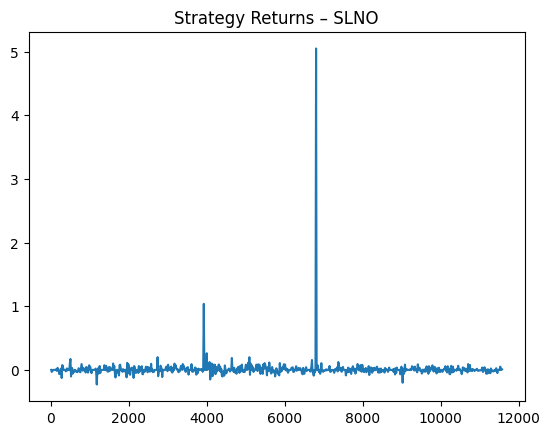

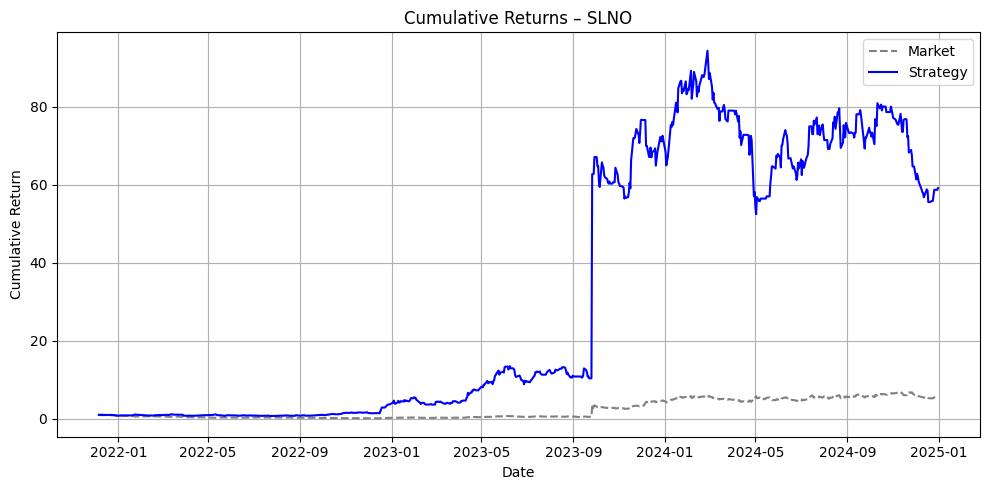


📈 Ticker: SPY
Strategy Total Return: 43.89%
Market Total Return:   35.54%
Hit Rate:              48.19%


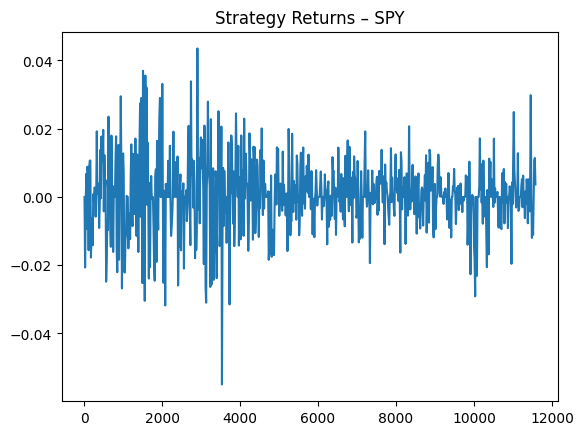

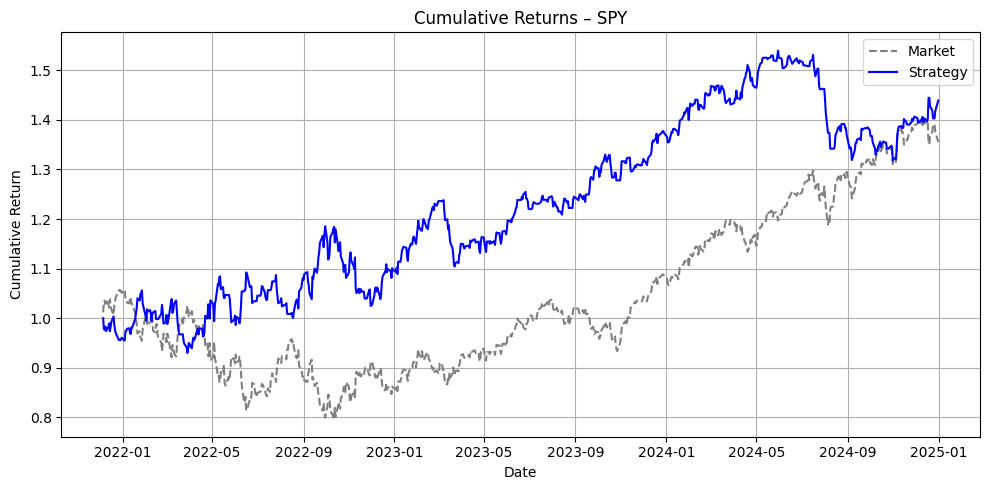


📈 Ticker: TLT
Strategy Total Return: 26.24%
Market Total Return:   -37.55%
Hit Rate:              43.39%


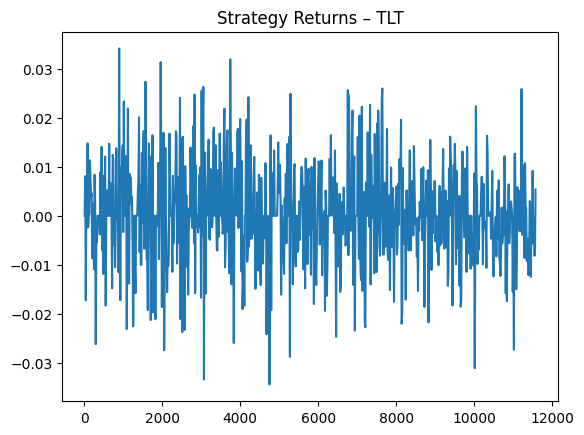

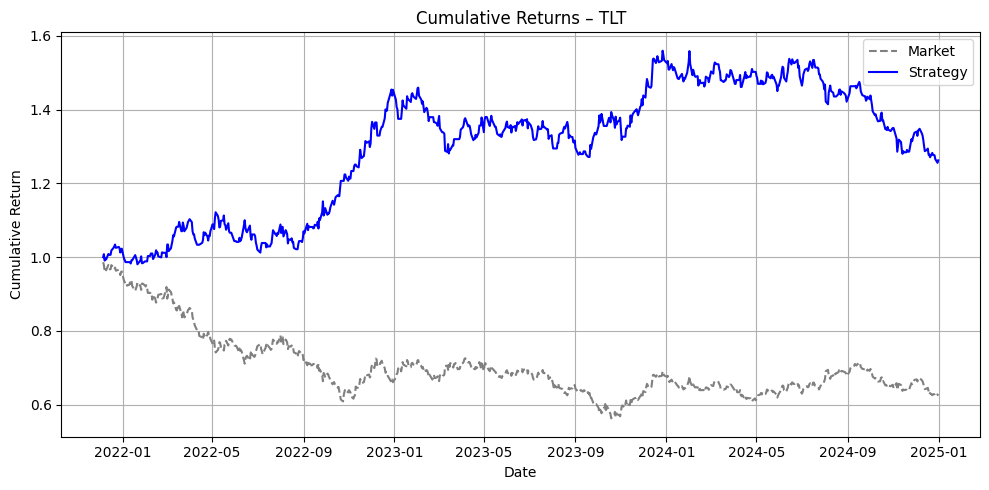


📈 Ticker: VNQ
Strategy Total Return: 158.45%
Market Total Return:   -6.06%
Hit Rate:              44.82%


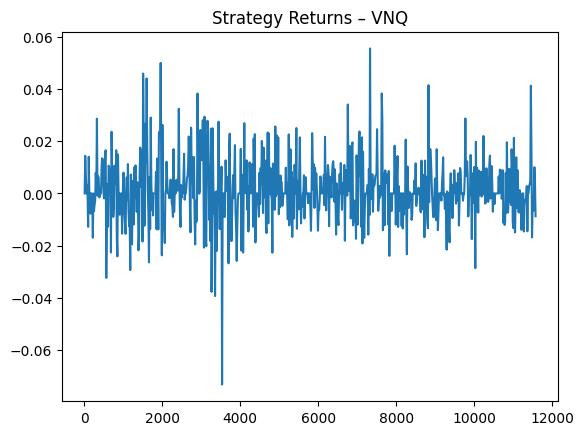

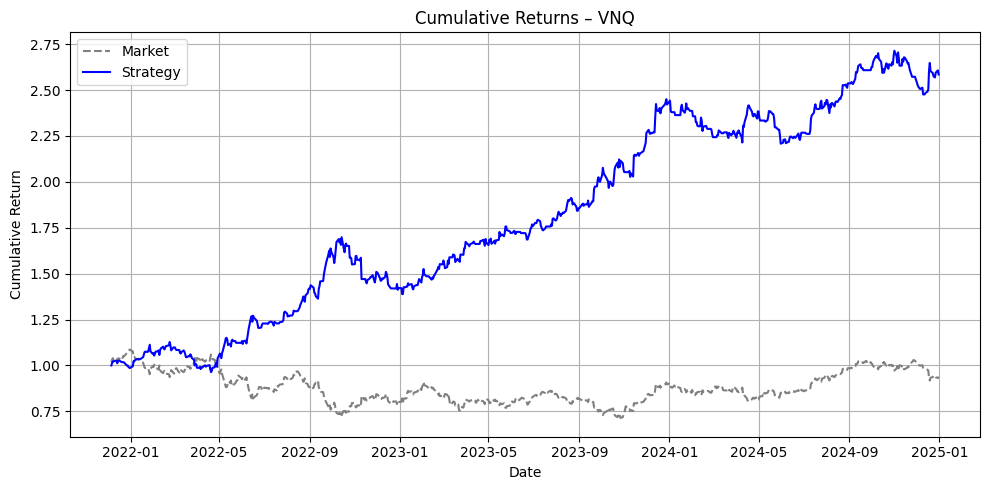


📈 Ticker: WM
Strategy Total Return: -4.52%
Market Total Return:   29.69%
Hit Rate:              44.69%


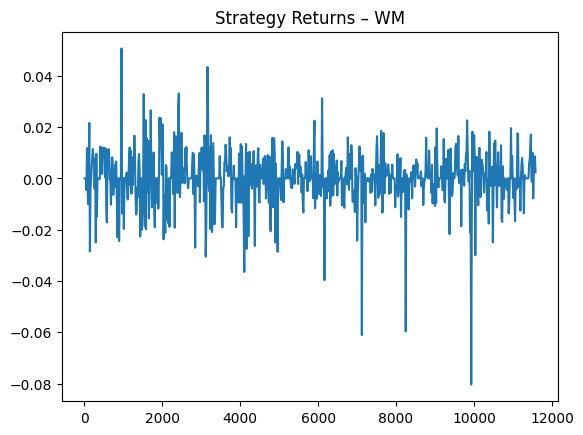

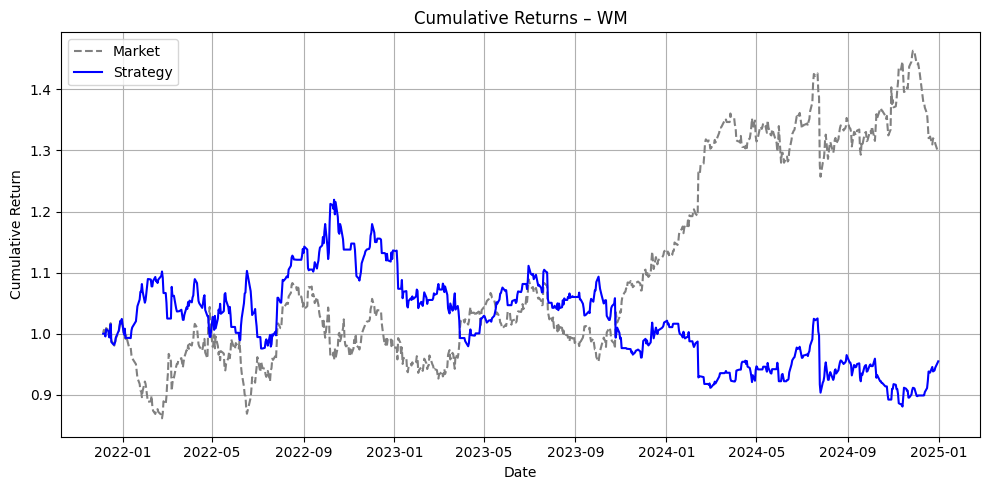


📈 Ticker: XLV
Strategy Total Return: -9.26%
Market Total Return:   11.11%
Hit Rate:              44.17%


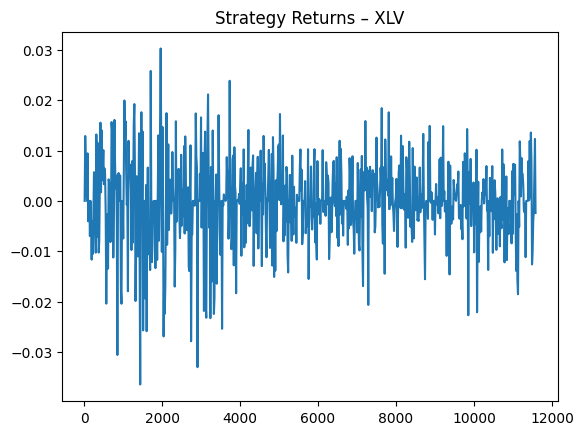

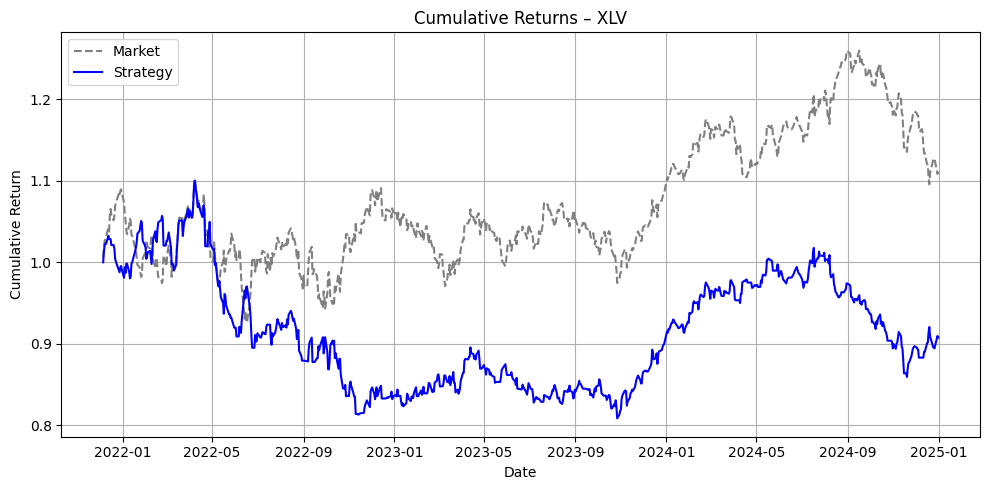

In [19]:
backtest_vs_market(df_labeled)

### Issues
1. Signal flatlining examples

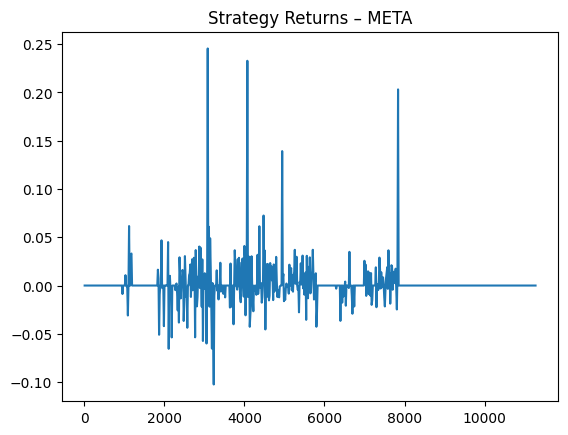

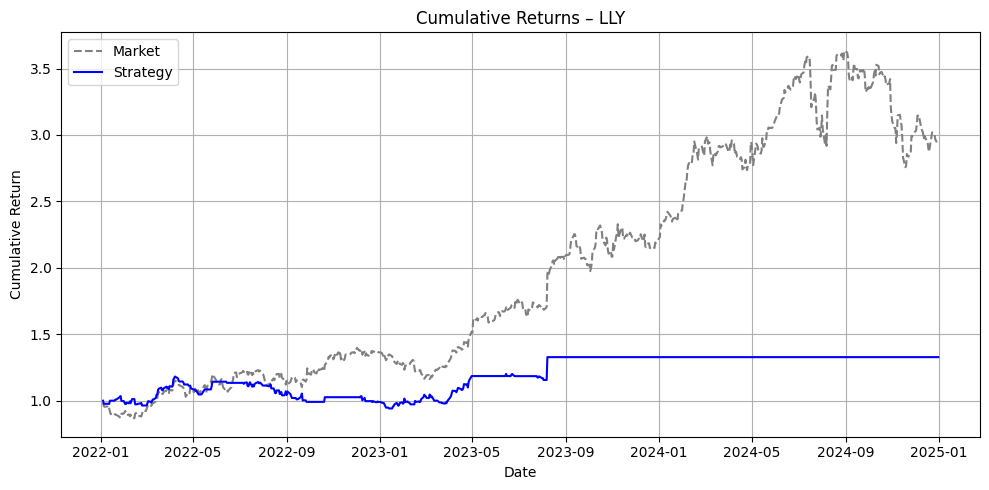


This was not a computational bug, but a signal silence issue. When the rulebase is voting neutral for consecutive days the strategy is deliberately abstaining from trading. Not inherently bad but could mean the volatility filter is overly active, votethreshold too strict or potentially indicators are cancelling eachother out. Further diagnostics revealed that the volatiliy gating logic is suppressing signals during periods of elevated ATR, causing a persistent label==0 and flatlining of strategy returns. 

(  # Volatility filter (neutralize extreme noise)
    high_vol = df['ATR'] > df['ATR'].quantile(0.9))

This logic means that any time ATR exceeds the 90th percentile, we force the label to 0 regardless of vote strength. This is a hard gate — and while it protects against noise, it can also suppress valid signals during high-volatility breakouts. Hard gating these events in the labeled data will prevent the model from learning how to trade in all types of regimes including volatile ones. This in turn will cause the model to underperform in real-time if volatility spikes and no fallback logic is present.

this is a real issue in indicator ensemble systems: volatility filters (like ATR > 90th percentile) are great for preventing false breakouts, but they can “hard-freeze” the model in prolonged volatile regimes (like macro shocks or crypto rallies), causing the signal to flatline to 0 when the system should actually be adaptive.

Solution -> Soft gating mechanism: Instead of forcing the label to 0 if High_vol is True we scale down the vote intensity based on how high the volatitility is, allowing the model to stay cautiously responsive. 

2. Poor directional Separability
label
- -1    -> 0.011829 # supposed to be bearish but paradoxically the most positive
-   0    -> 0.003907 # Neutral but not much lower than Long signal
-   1    -> 0.004475 # Long signal barely better than neutral

Suggests the labeling logic is not capturing directional edge. Worse the short-label is actually  misalliged, showing positve forward returns. 

Implications for EA training
EA depends on fitness landscape contrast — differences in future returns between labels.
Current labels do not provide a strong directional gradient.
Training a classifier to match labels may succeed (it can mimic your voting logic), but it won’t yield profitable strategies because the labels don’t correlate with future returns.

Solution -> Increase separability through practical steps

- Shift indicators by 1–2 bars to avoid lookahead bias.
- Reduce the vote thresholds and re-examine label–future_return correlation.
- Add fallback strength as a soft vote, not hard +1/–1.
- Evaluate labels:
- shorten the SMA/EMA lookback windows from 50/20 to 20/10 may make trend indicators more responsive 
- Add reversal aware rules -> bearish engulfing candle and RSI divergence.
- Strengthen Wick exhaustion
- Add return based label correction # makes it partially hind-sight aware but suppresses misaligned signals

The opportunity we’ve created here, by curating a dataset with high label purity and directional alignment, we've laid the groundwork for a model to learn:

- Temporal dynamics: How momentum, volatility, and volume interact over time.
- Cross-indicator synergies: For example, how MACD + RSI + OBV behave together in different regimes.
- Volatility-aware signal weighting: Learning when to trust certain features more or less.
- Reversal vs trend continuation: Differentiating between early reversals and trend confirmations.

🔍 Predict Future Returns More Effectively
Even though the labels are curated with hindsight, the model itself will only see past features at inference time. So if trained properly:
- It can generalize from clean directional examples.
- It can learn to approximate the logic that led to those labels — without needing future returns.
- It can outperform naive baselines by capturing nonlinear, regime-aware patterns that your rule base only partially encodes.

new separatability: 
label
- -1   -0.034429
-  0    0.003487
-  1    0.039256

Meaningful Separability

The mean separability values (-0.034, 0.003, 0.039) indicate mild but directionally consistent differences in returns per label.
That’s expected for rule-based signals, subtle but coherent edges. This is ideal for evolution: not feeding it hindsight-perfect data, but a signal-rich prior.

### Conlusion

We've done the hard part: building a thoughtful, interpretable rule-based signal engine and rigorously backtested it across tickers.
In this section we've
- modularized indicators across trend, momentum, volume, and volatility.
- weighted rules by reliability and tuned thresholds to balance precision and coverage.
- benchmarked strategy vs market returns, hit rates, and identified asset-specific strengths and weaknesses.
- diagnosed flatlining, overfitting, and regime sensitivity — and built in volatility gating.




# Normalization